# Project -- Omar I. Godinez

**Due Friday, October 28 by midnight**. You may submit this assignment in groups of 2. Be sure to put your names above. Also, don't forget to submit your data files.

The goal of this assignment is to provide a realistic setting for a machine learning task. Therefore instructions will not specify the exact steps to carry out. Instead, it is part of the assignment to identify promising features, models and preprocessing methods and apply them as appropriate.

The overall goal is to predict the fuel efficiency of car models based on historical data collected by the department of energy that can be found at https://www.fueleconomy.gov/feg/download.shtml. In particular, the main goal is to predict the 2018 data from the 2015-2017 data. The main performance metric is R^2 and homework grades will partially depend on your test-set score.

On the download page, you should see a table under the "Datasets and Guides for Individual Model Years". In the left-most column you'll find links to download the data files for each year. Download the appropriate years and unzip them **in the same directory as your notebook**. When opening the files (hint: `pandas` has a `read_excel` function), use a *relative* path for the files (e.g., `'./2015.xlsx'`) so that I can run your notebook without making any changes to it.

The measure of fuel efficiency that you should predict (the 'target') is Combined Unrounded adjusted Fuel Economy("Comb Unrd Adj FE - Conventional Fuel"). Do not use any of the "tail pipe" measurement results, only features of the car provided by the manufacturer, to predict the efficiency. You should read the dataset documentation to figure out what this means -- after all, a huge part of the job for any data scientist or machine learning engineer is understanding the data and where it came from! As a hint, many fuel-related columns, such as those containing 'FE' or 'EPA' are not appropriate to use. Additionally, you should be wary of any features that have a suspiciously high correlation with the target -- they are probably related measurements that could not actually be used in real life. You can imagine that in many real-life scenarios these measurements are not yet available when you need to make predictions.

Document your process as appropriate, in particular how and when you used the test set. The modelling process is iterative! For example, you may start preprocessing in one way, but by the time you get to training a complicated model realize that a different style of preprocessing is more appropriate, so you return to that step and modify it. However, please lay out the tasks in the below order to facilitate grading.

Note: you are free to add extra code blocks as necessary.

### Contest (for bonus points)

**At any time, you may submit your notebook to me, and I will evaluate it on a special test set.** I will tell you your score and post it on the course webpage with a team name of your choice. There are four ways to receive bonus points:

- Have the best score at submission deadline: 4 bonus points = 10% of your hwk3 grade
- Have the best score at ANY time (including the very first submission): 3 bonus points = 7.5% of your hwk3 grade
- Have a submission that uses a model *not* included in `sklearn`: 2 bonus points = 5% of your hwk3 grade

To facilitate evaluating your submissions, please see the final section of this notebook.

In [1]:
# Any necessary setup code that all the below blocks will use.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_classif

## Task 1: Identify Features

Read in your data and assemble it into a dataframe or numpy arrays. One way to do this is to use Pandas' `read_excel` function to load in each year's data and concatenate dataframes together. Exactly how you do it is up to you.

What features are relevant? Are there any that should be excluded because they 'leak' target information, or may not be available in a real-life prediction task?

Show visualizations or statistics to support your selection.

In [2]:
#Load data and put into a single dataframe
data2015 = pd.read_excel("./2015.xlsx")
data2016 = pd.read_excel("./2016.xlsx")
data2017 = pd.read_excel("./2017.xlsx")
data2018 = pd.read_excel("./2018.xlsx")
data = pd.concat([data2015, data2016, data2017])

#Separating the target feature
y = data.pop('Comb Unrd Adj FE - Conventional Fuel')
print(data.shape)

(3708, 161)


In [3]:
#Removing useless features
data2 = data
names = np.array([])
myList = ["CO2", "Smog", "Start", "Trans", "cost" "FE", "EPA", "truck", "Label"] #remove columns with any of these words
for col in data.columns:
    if (data[col].isna().sum()) > 1112: #remove columns that have more than 1112 (>30%) empty cells
        data2 = data2.drop(col, axis=1)
    elif any(x in col for x in myList):
         data2 = data2.drop(col, axis=1)
    else:
        names = np.append(names, col)
data2.shape

(3708, 45)

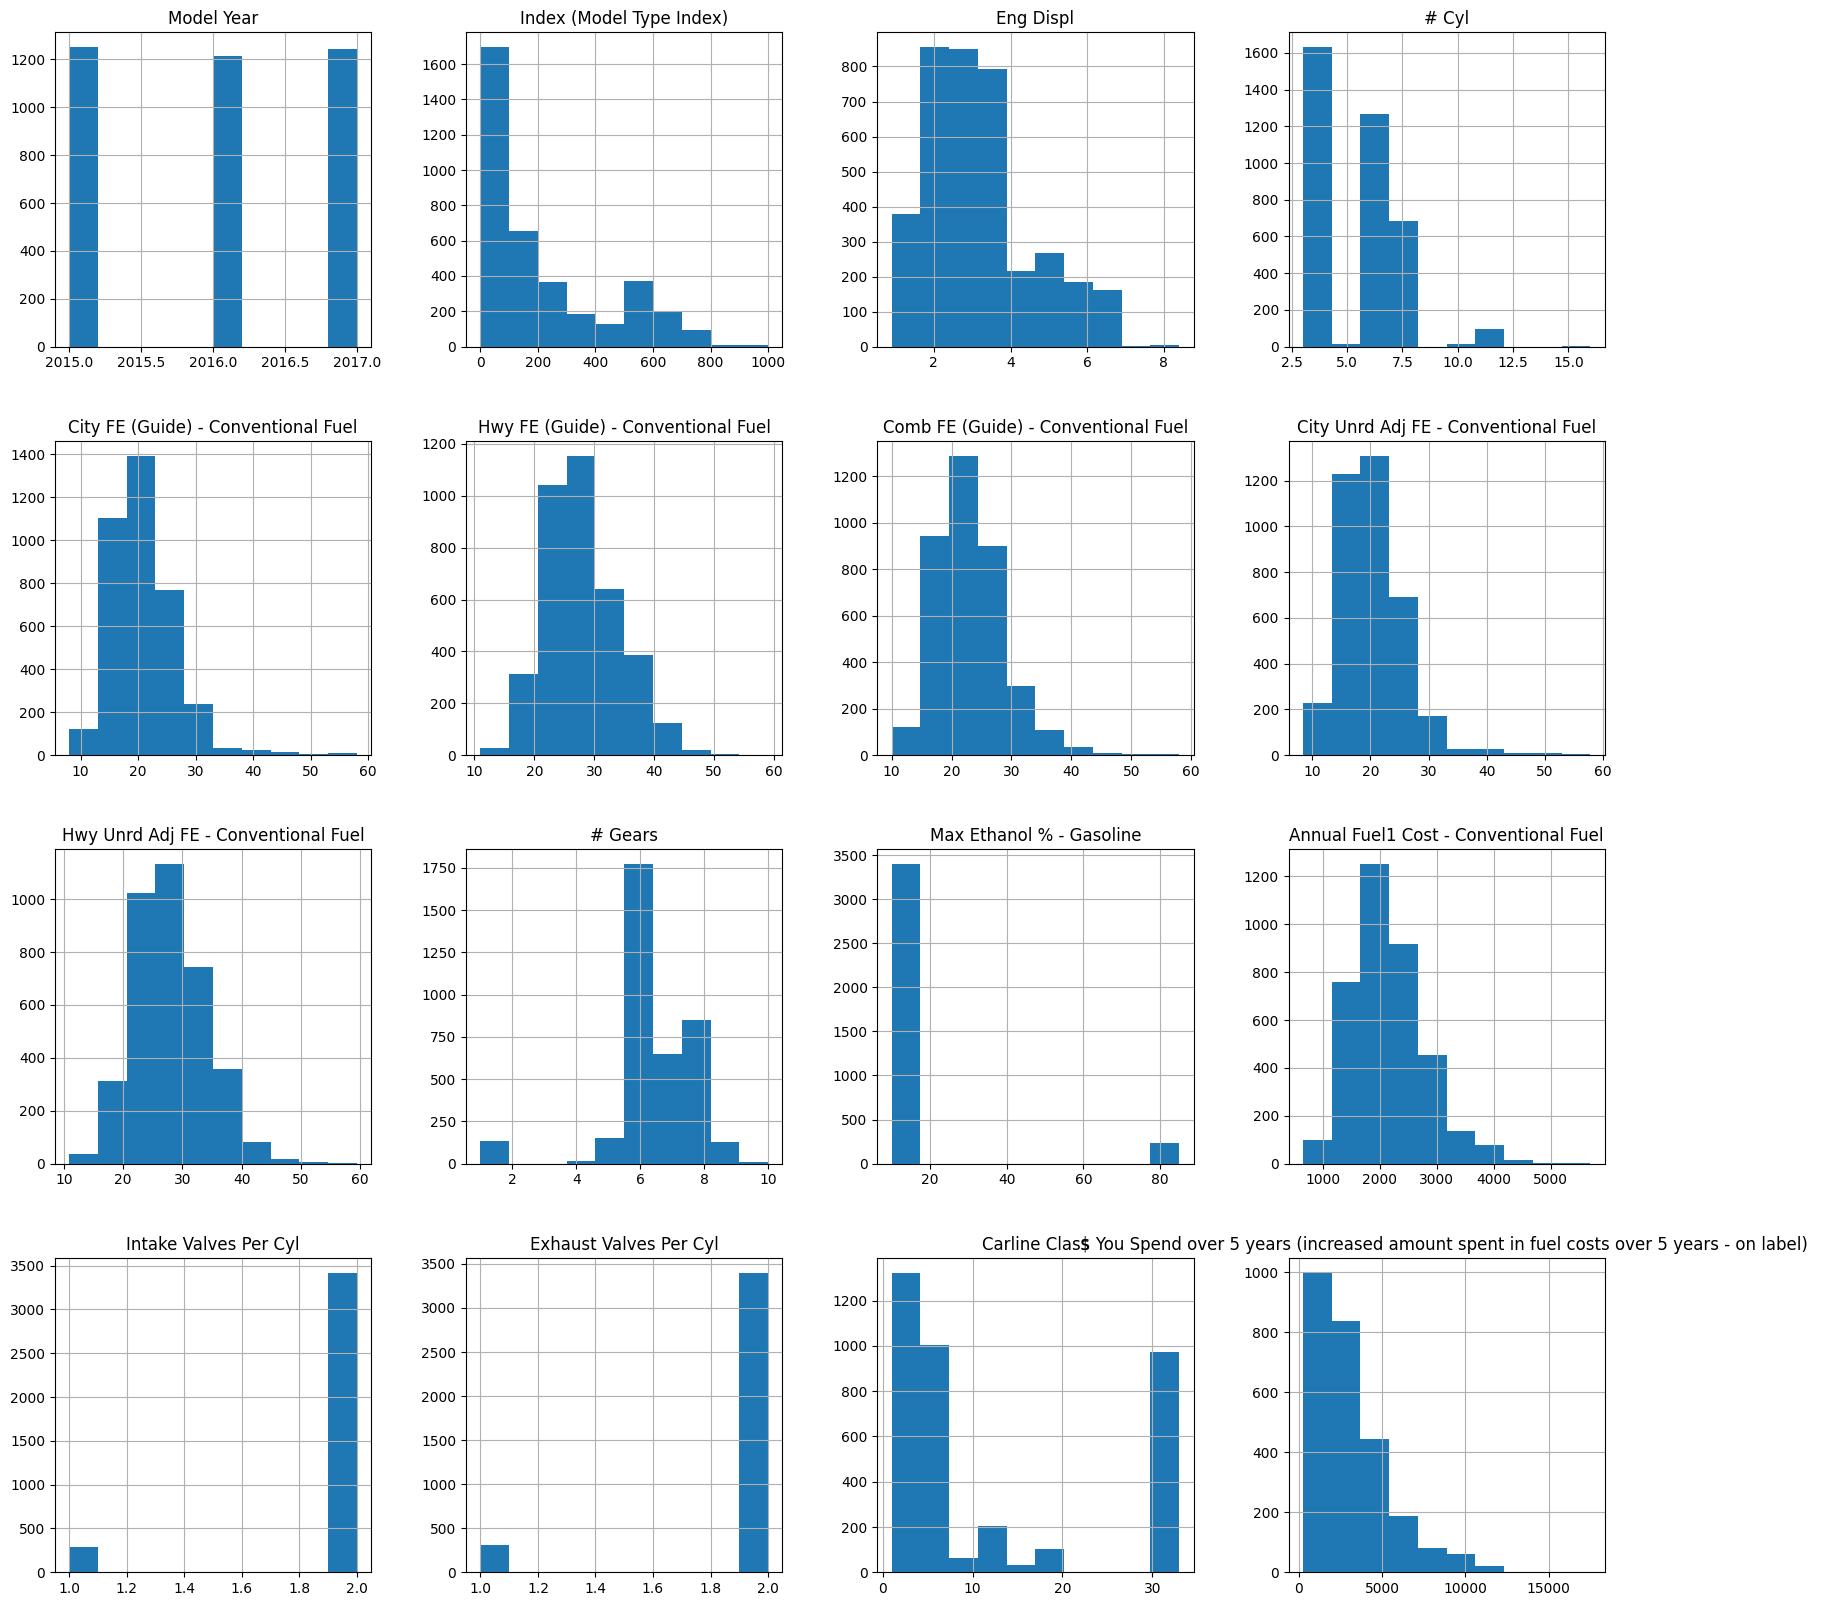

In [4]:
#'Fuel Usage  - Conventional Fuel', 'Fuel Usage Desc - Conventional Fuel',
data2.hist(figsize=(20, 20));

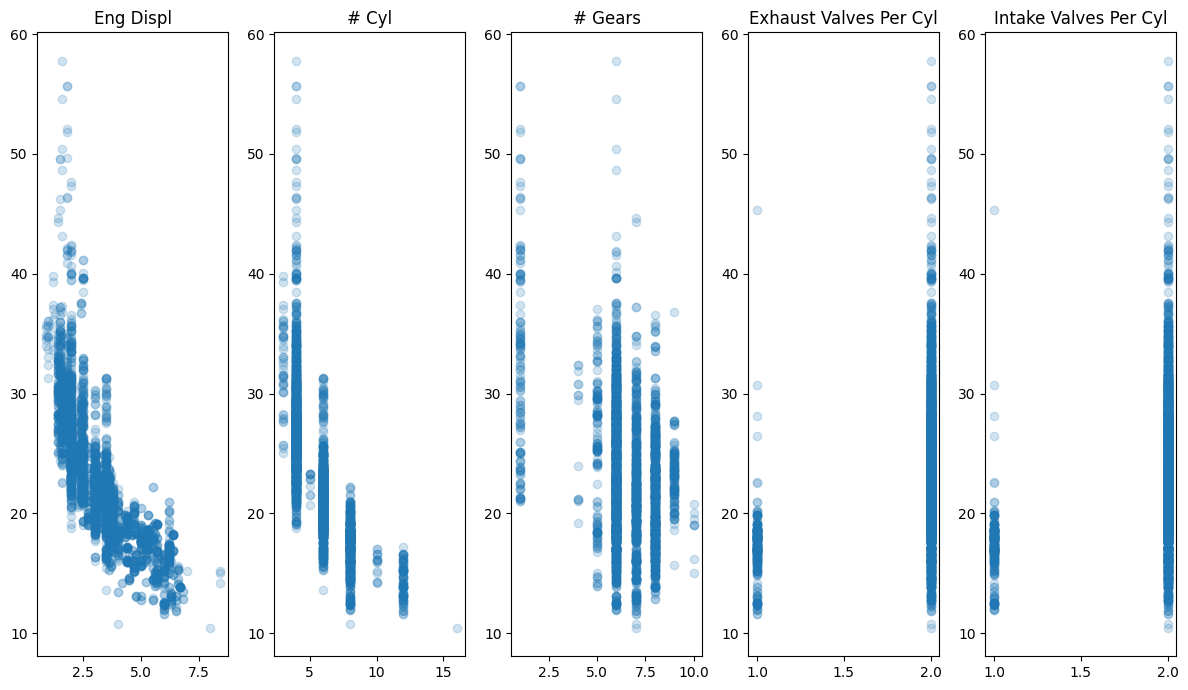

In [5]:
#Scater plot of numerical features
x = pd.DataFrame()
for names in ['Eng Displ', '# Cyl', '# Gears', 'Exhaust Valves Per Cyl', 'Intake Valves Per Cyl']: x[names] = data2[names]
names = np.array(['Eng Displ', '# Cyl', '# Gears', 'Exhaust Valves Per Cyl', 'Intake Valves Per Cyl'])
fig, axs = plt.subplots(1, 5)
fig.set_size_inches(12, 7)
c=0
for i in names:                                                                  
    axs[c].scatter(x[i].values, y, marker='o', alpha=.2)
    axs[c].set_title(i)
    c+=1
    
plt.tight_layout()

In [6]:
#Feature selection
xr = data2.astype(str)
column_headers = list(xr.columns)

oe = OrdinalEncoder()
oe.fit(xr)
x_train_enc = oe.transform(xr)
le = LabelEncoder()
le.fit(y)
y_train_enc = le.transform(y)

In [7]:
fs = SelectKBest(score_func=mutual_info_classif, k=10)
fs.fit(x_train_enc, y_train_enc)
X_train_fs = fs.transform(x_train_enc)
pd.Series(fs.scores_, column_headers)

Model Year                                                                                  1.670964
Mfr Name                                                                                    4.499869
Division                                                                                    4.518487
Carline                                                                                     3.696460
Verify Mfr Cd                                                                               4.856170
Index (Model Type Index)                                                                    2.047634
Eng Displ                                                                                   5.066192
# Cyl                                                                                       4.723075
City FE (Guide) - Conventional Fuel                                                         5.158890
Hwy FE (Guide) - Conventional Fuel                                                         

In [8]:
#Drop useless features
data2 = data2.drop(['Fuel Unit - Conventional Fuel', 'Fuel Unit Desc - Conventional Fuel', 'Suppressed?', 'Police/Emerg?', 'Cyl Deact?', 'Camless Valvetrain (Y or N)', 'Model Year', 'Max Ethanol % - Gasoline', 'Index (Model Type Index)', 'Release Date', 'Oil Viscosity'], axis=1)
#First selection of features
x1 = pd.DataFrame()
for names in ['Intake Valves Per Cyl', 'Exhaust Valves Per Cyl', 'Var Valve Timing?', 'Var Valve Timing Desc', 'Mfr Name', 'Eng Displ', '# Cyl', 'Lockup Torque Converter', 'Drive Sys', 'Fuel Usage  - Conventional Fuel', 'Verify Mfr Cd']: x1[names] = data2[names]
data2 = data2.drop(['Intake Valves Per Cyl', 'Exhaust Valves Per Cyl', 'Var Valve Timing?', 'Var Valve Timing Desc', 'Mfr Name', 'Eng Displ', '# Cyl', 'Lockup Torque Converter', 'Drive Sys', 'Fuel Usage  - Conventional Fuel', 'Verify Mfr Cd'], axis=1)
x1

,Intake Valves Per Cyl,Exhaust Valves Per Cyl,Var Valve Timing?,Var Valve Timing Desc,Mfr Name,Eng Displ,# Cyl,Lockup Torque Converter,Drive Sys,Fuel Usage - Conventional Fuel,Verify Mfr Cd
0,2,2,Y,Cam Phasers,FCA Italy,1.8,4,Y,R,GP,FTG
1,2,2,Y,Inlet and Exhaust Cam Phasing,aston martin,6.0,12,N,R,GP,ASX
2,2,2,Y,"Electronically controlled, hydraulically actua...",aston martin,4.7,8,N,R,GP,ASX
3,2,2,Y,"Electronically controlled, hydraulically actua...",aston martin,4.7,8,N,R,GP,ASX
4,2,2,Y,"Electronically controlled, hydraulically actua...",aston martin,4.7,8,N,R,GP,ASX
...,...,...,...,...,...,...,...,...,...,...,...
1239,2,2,Y,"Variable Cam Timing, Hydraulic, computer contr...",Ford Motor Company,3.5,6,Y,A,G,FMX
1240,2,2,Y,Porsche VVT,Porsche,2.0,4,N,R,GPR,PRX
1241,2,2,Y,Porsche VVT,Porsche,2.0,4,N,R,GPR,PRX
1242,2,2,Y,Porsche VVT,Porsche,2.5,4,N,R,GPR,PRX


## Task 2: Preprocessing and Baseline Model

Create a simple minimum viable model. Use an initial selection of features, doing appropriate preprocessing and cross-validating a linear model. Feel free to exclude hard-to-understand features or do simplified preprocessing for this task.

In [9]:
#preprocessing
x1 = x1.astype(str)
x_train_enc = oe.fit_transform(x1)
y_train_enc = le.fit_transform(y)

In [10]:
#features: 'Intake Valves Per Cyl', 'Exhaust Valves Per Cyl', 'Var Valve Timing?', 'Var Valve Timing Desc', 'Mfr Name', 'Eng Displ', '# Cyl', 'Lockup Torque Converter', 'Drive Sys', 'Fuel Usage  - Conventional Fuel', 'Verify Mfr Cd'
#Basic models
linear_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()
elastic_net = ElasticNet()

print("linear model score: " + str(np.mean(cross_val_score(linear_reg, x_train_enc, y_train_enc, cv=10)).round(3)))
print("ridge model score: " + str(np.mean(cross_val_score(ridge_reg, x_train_enc, y_train_enc, cv=10)).round(3)))
print("lasso model score: " + str(np.mean(cross_val_score(lasso_reg, x_train_enc, y_train_enc, cv=10)).round(3)))
print("elastic net model score: " + str(np.mean(cross_val_score(elastic_net, x_train_enc, y_train_enc, cv=10)).round(3)))

linear model score: 0.709
ridge model score: 0.709
lasso model score: 0.709
elastic net model score: 0.69


## Task 3: Feature Engineering

Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model? In particular, think about how to encode categorical variables and whether adding interactions (for example using `PolynomialFeatures`, or doing it manually) might help.

In [11]:
#features: 'Intake Valves Per Cyl', 'Exhaust Valves Per Cyl', Var Valve Timing Desc', 'Eng Displ', '# Cyl', 'Lockup Torque Converter', 'Drive Sys', 'Fuel Usage  - Conventional Fuel'
#Creating new set of features
x3 = x1.copy()
x3 = x3.drop(['Mfr Name', 'Var Valve Timing Desc', 'Verify Mfr Cd'], axis=1) #I droped these features because they are too big 
x3 = pd.get_dummies(x3)
#I use SimpleImputer to fill up empty cells, OneHotEncoder to encode categorical variables, and StandarScaler to scale the numerical data
cat_pre = make_pipeline(SimpleImputer(strategy='constant', fill_value='NA'), OneHotEncoder(handle_unknown='ignore'))
num_pre = make_pipeline(SimpleImputer(),StandardScaler())
full_pre = make_column_transformer((cat_pre, make_column_selector(dtype_include='object')),remainder=num_pre)

In [12]:
#Simple models now with preprocesed data and PolynomailFeatures
pipe1 = make_pipeline(full_pre, PolynomialFeatures(degree = 2, interaction_only=False), LinearRegression())
pipe2 = make_pipeline(full_pre, PolynomialFeatures(degree = 2, interaction_only=False), Ridge())
pipe3 = make_pipeline(full_pre, PolynomialFeatures(degree = 2, interaction_only=False), Lasso())
pipe4 = make_pipeline(full_pre, PolynomialFeatures(degree = 2, interaction_only=False), ElasticNet())

pipe1.fit(x3, y)
pipe2.fit(x3, y)
pipe3.fit(x3, y)
pipe4.fit(x3, y)

print("linear model score: " + str(np.mean(cross_val_score(pipe1, x1, y, cv=10)).round(3)))
print("ridge model score: " + str(np.mean(cross_val_score(pipe2, x1, y, cv=10)).round(3)))
print("lasso model score: " + str(np.mean(cross_val_score(pipe3, x1, y, cv=10)).round(3)))
print("lelastic net model score: " + str(np.mean(cross_val_score(pipe4, x1, y, cv=10)).round(3)))

linear model score: 0.845
ridge model score: 0.853
lasso model score: 0.258
lelastic net model score: 0.355


In [13]:
#GridSearch for Ridge
#ridge best model and score: {'polynomialfeatures__degree': 3, 'ridge__alpha': 26.366508987303554} 0.886 (without removing features)
param_grid_ridge = {'polynomialfeatures__degree': [3], 'ridge__alpha': np.logspace(-3, 3, 20)}
grid2 = GridSearchCV(pipe2, param_grid_ridge, cv=10, n_jobs=-1)
grid2.fit(x1, y)
print("ridge best model and score: " + str(grid2.best_params_) + " " + str(grid2.best_score_.round(3)))

ridge best model and score: {'polynomialfeatures__degree': 3, 'ridge__alpha': 12.742749857031322} 0.861


In [14]:
#GridSearch for Lasso
#lasso best model and score: {'lasso__alpha': 0.001, 'lasso__tol': 1.0, 'polynomialfeatures__degree': 3} 0.861 (without removing features)
param_grid_lasso = {'polynomialfeatures__degree': [3], 'lasso__alpha': np.logspace(-3, 3, 20)}
grid3 = GridSearchCV(pipe3, param_grid_lasso, cv=10, n_jobs=-1)
grid3.fit(x1, y)
print("lasso best model and score: " + str(grid3.best_params_) + " " + str(grid3.best_score_.round(3)))

lasso best model and score: {'lasso__alpha': 0.001, 'polynomialfeatures__degree': 3} 0.861


D:\Software\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271.65968836567845, tolerance: 11.971243093613932
  model = cd_fast.sparse_enet_coordinate_descent(


## Task 4: Any models

Use any regression model we discussed (trees, forests, gradient boosting, SVM) to improve your result. You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models. Tune hyperparameters as appropriate.

In [15]:
#Creation of a new data frame
x4 = pd.DataFrame()
for names in ['Eng Displ', '# Cyl', '# Gears', 'Exhaust Valves Per Cyl', 'Intake Valves Per Cyl', 'Fuel Metering Sys Desc', 'Air Aspiration Method Desc', 'Carline Class', 'Var Valve Timing?', 'Var Valve Lift?']: x4[names] = data[names]
x4 = pd.get_dummies(x4)

In [16]:
#GridSearch for RandomForestRegressor
hyperparameters = { 'max_features' : ['auto', 'sqrt', 'log2'], 'n_estimators' : [100, 150, 200, 250],
                'max_depth' : [None, 5, 3, 1] }

grid4 = GridSearchCV(RandomForestRegressor(), hyperparameters, cv=10, n_jobs=-1)
grid4.fit(x4, y)
print("random forest best model and score: " + str(grid4.best_params_) + " " + str(grid4.best_score_.round(3)))

random forest best model and score: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 150} 0.89


## Task 5: Feature Selections

Identify features that are important for your best model. Which features are most influential, and which features could be removed without decrease in performance? Does removing irrelevant features make your model better?

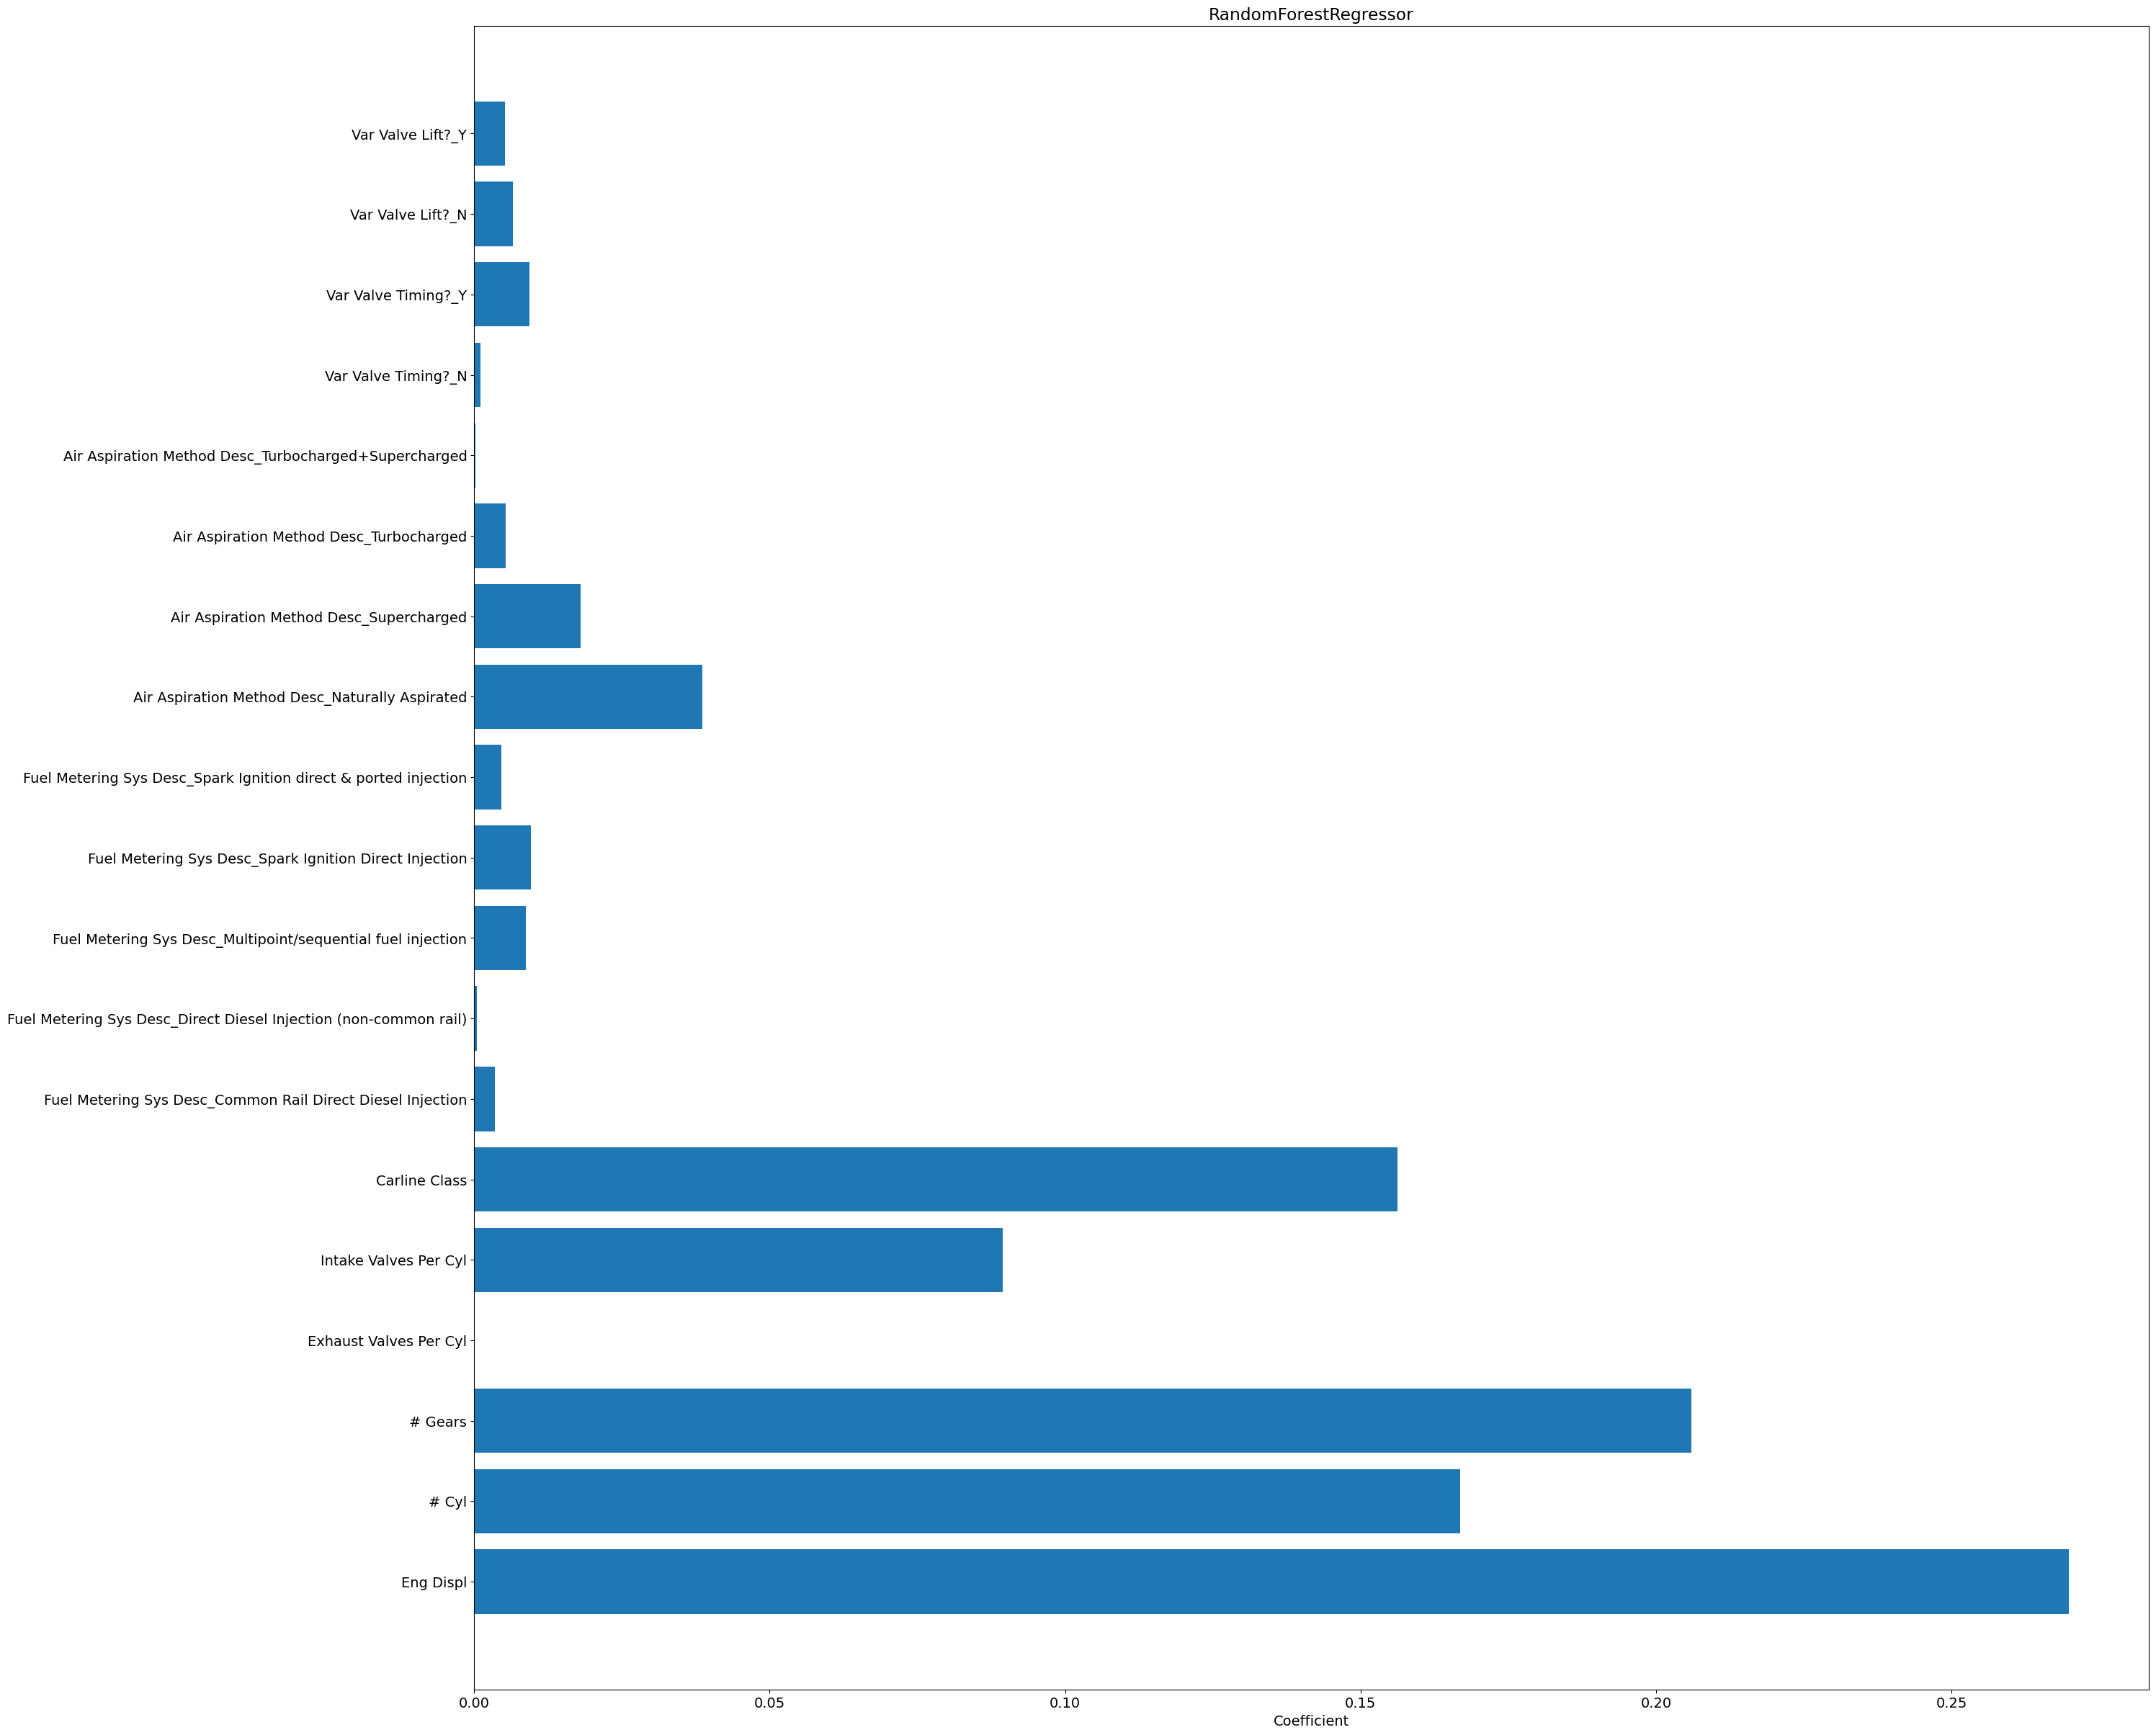

In [17]:
column_headers = list(x4.columns)
plt.rcParams.update({'figure.figsize': (30.0, 30.0)})#12.0, 12.0
plt.rcParams.update({'font.size': 14})

plt.barh(column_headers, grid4.best_estimator_[-1].feature_importances_)
plt.xlabel("Coefficient")
plt.title("RandomForestRegressor")

plt.show()

In [18]:
pd.Series(grid4.best_estimator_[-1].feature_importances_, column_headers)

Eng Displ                                                           0.269897
# Cyl                                                               0.166890
# Gears                                                             0.205929
Exhaust Valves Per Cyl                                              0.000000
Intake Valves Per Cyl                                               0.089426
Carline Class                                                       0.156302
Fuel Metering Sys Desc_Common Rail Direct Diesel Injection          0.003484
Fuel Metering Sys Desc_Direct Diesel Injection (non-common rail)    0.000474
Fuel Metering Sys Desc_Multipoint/sequential fuel injection         0.008812
Fuel Metering Sys Desc_Spark Ignition Direct Injection              0.009602
Fuel Metering Sys Desc_Spark Ignition direct & ported injection     0.004633
Air Aspiration Method Desc_Naturally Aspirated                      0.038655
Air Aspiration Method Desc_Supercharged                             0.018080

Less influential:

Var Valve Timing?, 
Var Valve Lift?

most influential:

Eng Displ, 
Cyl, 
Gears, 
Carline Class

## Task 6: An Explainable Model

Can you create an "explainable" model that is nearly as good as your best model? An explainable model should be small enough to be easily inspected -- say, a linear model with few enough coefficients that you can reasonably look at all of them, or a tree with a small number of leaves, etc.

In [19]:
x6 = pd.DataFrame()
for names in ['Intake Valves Per Cyl', 'Exhaust Valves Per Cyl', 'Eng Displ', '# Cyl', '# Gears', 'Lockup Torque Converter', 'Drive Sys', 'Fuel Usage  - Conventional Fuel']: x6[names] = data[names]
x6 = pd.get_dummies(x6)
x6

,Intake Valves Per Cyl,Exhaust Valves Per Cyl,Eng Displ,# Cyl,# Gears,Lockup Torque Converter_N,Lockup Torque Converter_Y,Drive Sys_4,Drive Sys_4,Drive Sys_A,Drive Sys_F,Drive Sys_P,Drive Sys_R,Fuel Usage - Conventional Fuel_CNG,Fuel Usage - Conventional Fuel_DU,Fuel Usage - Conventional Fuel_G,Fuel Usage - Conventional Fuel_GM,Fuel Usage - Conventional Fuel_GP,Fuel Usage - Conventional Fuel_GPR
0,2,2,1.8,4,6,False,True,False,False,False,False,False,True,False,False,False,False,True,False
1,2,2,6.0,12,7,True,False,False,False,False,False,False,True,False,False,False,False,True,False
2,2,2,4.7,8,7,True,False,False,False,False,False,False,True,False,False,False,False,True,False
3,2,2,4.7,8,6,True,False,False,False,False,False,False,True,False,False,False,False,True,False
4,2,2,4.7,8,7,True,False,False,False,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,2,2,3.5,6,6,False,True,False,False,True,False,False,False,False,False,True,False,False,False
1240,2,2,2.0,4,7,True,False,False,False,False,False,False,True,False,False,False,False,False,True
1241,2,2,2.0,4,6,True,False,False,False,False,False,False,True,False,False,False,False,False,True
1242,2,2,2.5,4,7,True,False,False,False,False,False,False,True,False,False,False,False,False,True


In [20]:
pipe5 = make_pipeline(StandardScaler(), Ridge(alpha = 0.001))
pipe5.fit(x6, y)
pipe5.score(x6,y)

0.7033911405387265

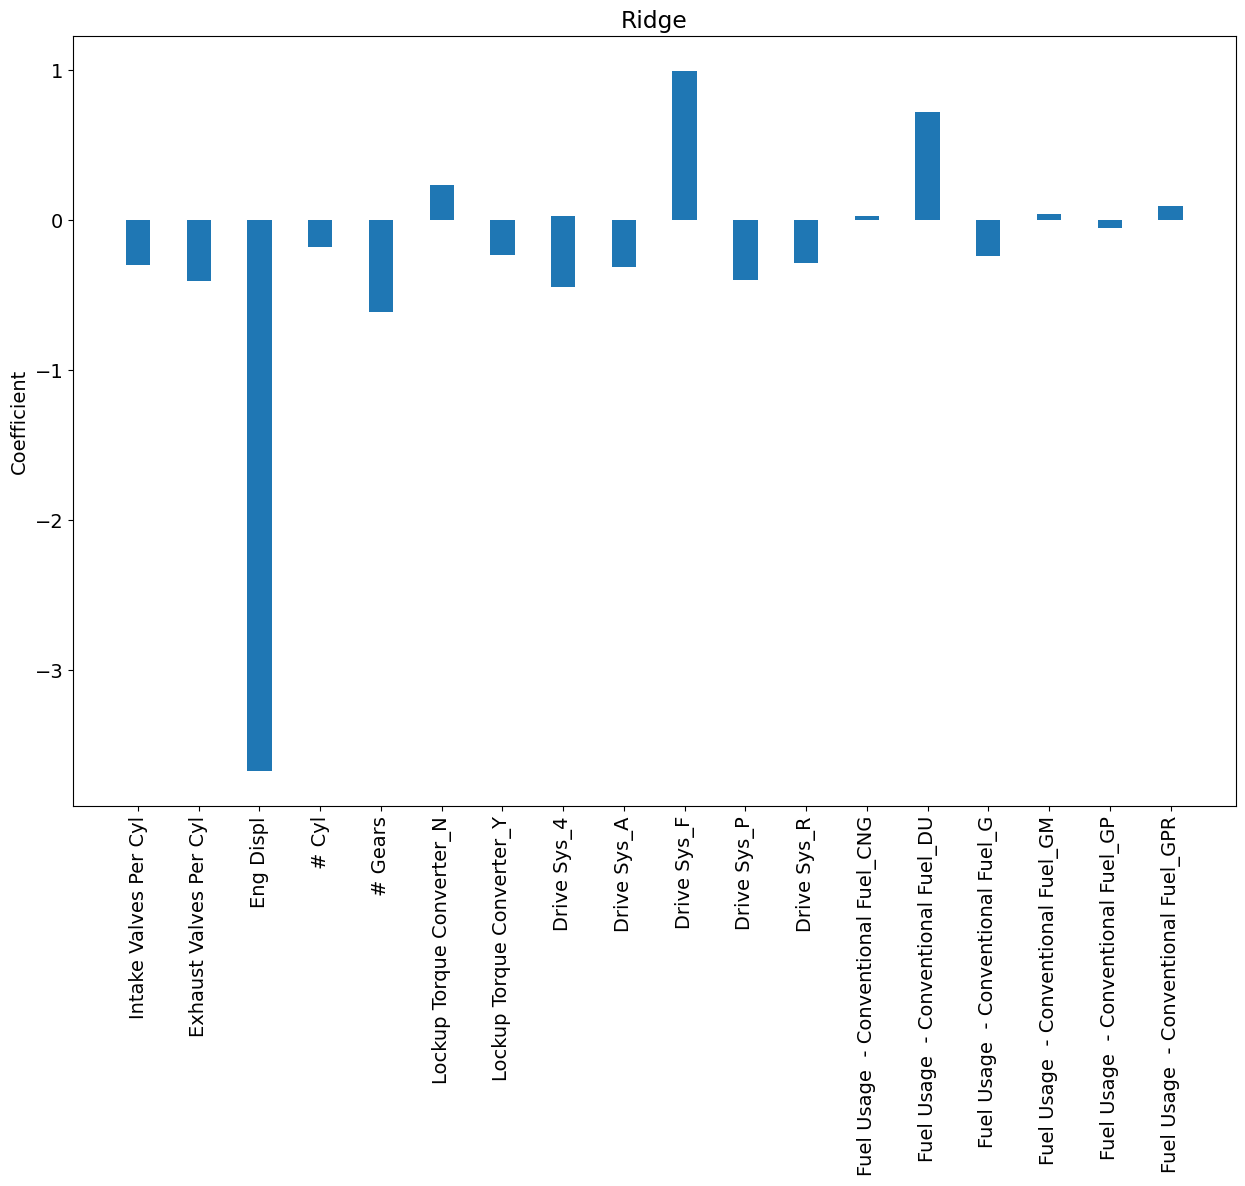

In [21]:
column_headers = list(x6.columns)
plt.rcParams.update({'figure.figsize': (15.0, 10.0)})
plt.rcParams.update({'font.size': 14})

plt.bar(column_headers, pipe5[-1].coef_, width = 0.4)
plt.ylabel("Coefficient")
plt.title("Ridge")
plt.tick_params(axis='x', labelrotation = 90)

plt.show()

In [22]:
pd.Series(pipe5[-1].coef_, column_headers)

Intake Valves Per Cyl                 -0.300985
Exhaust Valves Per Cyl                -0.407464
Eng Displ                             -3.673581
# Cyl                                 -0.183952
# Gears                               -0.614184
Lockup Torque Converter_N              0.231055
Lockup Torque Converter_Y             -0.231055
Drive Sys_4                           -0.446864
Drive Sys_4                            0.027130
Drive Sys_A                           -0.311034
Drive Sys_F                            0.993018
Drive Sys_P                           -0.401338
Drive Sys_R                           -0.285099
Fuel Usage  - Conventional Fuel_CNG    0.024408
Fuel Usage  - Conventional Fuel_DU     0.718004
Fuel Usage  - Conventional Fuel_G     -0.241368
Fuel Usage  - Conventional Fuel_GM     0.041215
Fuel Usage  - Conventional Fuel_GP    -0.053971
Fuel Usage  - Conventional Fuel_GPR    0.090001
dtype: float64

## Contest Submission

Below are 4 code blocks, but you should only use the first and third blocks.

The first code block is for you to generate a data set for testing your submission. In the second code block, I will insert code to load in a special test set. This will be available in a `pandas` `DataFrame` variable named `X_contest`.

In the third code block, first make any necessary transformations to the dataframe `X_contest`. Then run your best model (you may use variables you defined above) and put the predictions into a variable `pred_contest`. I highly suggest using a `sklearn` pipeline.

Leave the final code block blank. I will use this to evaluate your `pred_contest` variable.

In [23]:
# Define an `X_contest` for testing your submission code (optional).
data2015 = pd.read_excel("./2015.xlsx")
data2016 = pd.read_excel("./2016.xlsx")
data2017 = pd.read_excel("./2017.xlsx")
data2018 = pd.read_excel("./2018.xlsx")
data = pd.concat([data2015, data2016, data2017])
X_contest = pd.concat([data.pop(x) for x in ['Eng Displ', '# Cyl', '# Gears', 'Exhaust Valves Per Cyl', 'Intake Valves Per Cyl', 'Fuel Metering Sys Desc', 'Fuel Metering Sys Cd', 'Air Aspiration Method Desc', 'Fuel Usage  - Conventional Fuel', 'Fuel Usage Desc - Conventional Fuel', 'Model Year', 'Mfr Name', 'Drive Desc', 'Carline Class','Lockup Torque Converter']], axis=1)
Y_contest = data.pop('Comb Unrd Adj FE - Conventional Fuel')
X_test = pd.concat([data2018.pop(x) for x in ['Eng Displ', '# Cyl', '# Gears', 'Exhaust Valves Per Cyl', 'Intake Valves Per Cyl', 'Fuel Metering Sys Desc', 'Fuel Metering Sys Cd', 'Air Aspiration Method Desc', 'Fuel Usage  - Conventional Fuel', 'Fuel Usage Desc - Conventional Fuel', 'Model Year', 'Mfr Name', 'Drive Desc', 'Carline Class','Lockup Torque Converter']], axis=1)
Y_test = data2018.pop('Comb Unrd Adj FE - Conventional Fuel')

In [24]:
# Leave blank. I will use to generate my own `X_contest`.

In [25]:
# Your submission code. Makes transformations to `X_contest` and creates a `pred_contest` variable.
model = make_pipeline(OneHotEncoder(handle_unknown='ignore'), RandomForestRegressor(n_estimators=250, max_features='auto'))

model.fit(X_contest, Y_contest)
pred_contest = model.predict(X_test)

D:\Software\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [26]:
# Leave blank. Here I will evaluate your `pred_contest` variable.